# Building regularized softmax regression model for CIFAR10 using PyTorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, top_k_accuracy_score

# The CIFAR10 dataset
- Download and normalize the CIFAR10 dataset from torchvision
- Split the CIFAR10 data into train, validation and test set
- Set the batch size for processing these datasets
- Build the dataloaders for train, validation, and test set which will be used in the training loop
- Define the string class labels (targets are numeric 0-9)

In [ ]:
# mean and std for the RGB channels in CIFAR10
tmean = [0.49139968, 0.48215841, 0.44653091]
tstd = [0.24703223, 0.24348513, 0.26158784]

# transform the 32x32x3 images into a tensor after normalizing
# each channel using the parameters above
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tmean, tstd)])

# download and transform the  trainset and testset for training
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

#split trainset into a train and a val set (90-10 split)
lengths = [int(p * len(trainset)) for p in [0.9,0.1]]
tr,v = torch.utils.data.random_split(trainset,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

print("Number of training batches = ",len(trainloader))
print("Number of validation batches = ",len(valloader))
print("Number of test batches = ",len(testloader))

# define the output classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 64884286.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training batches =  352
Number of validation batches =  40
Number of test batches =  79


# Visualize the training data

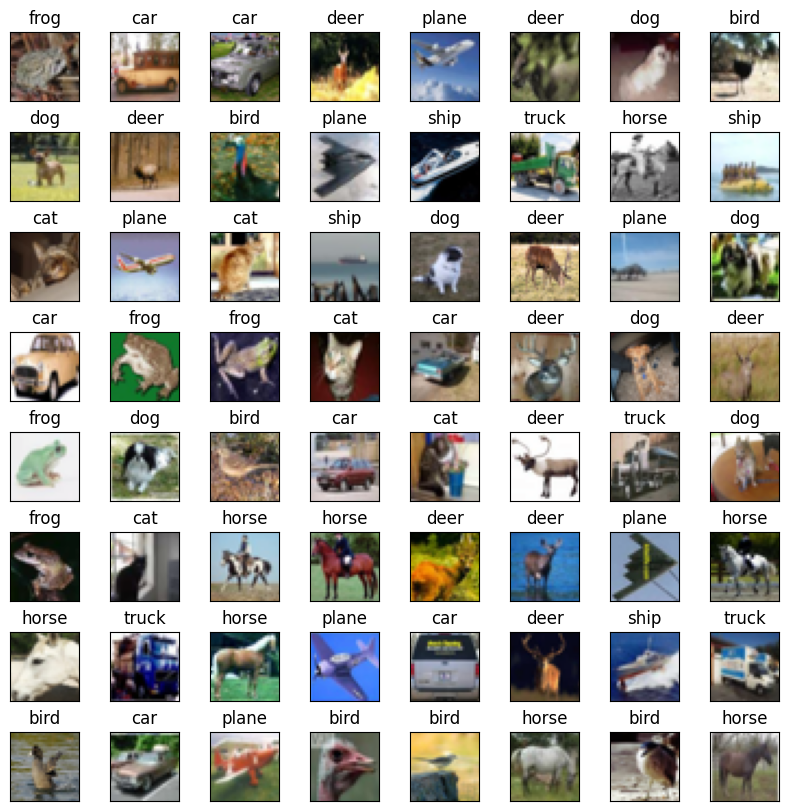

In [ ]:
Xtr,ytr = next(iter(trainloader))
# make a 8x8 grid and display 64 images from the first batch of training data
rows,cols = 8,8
fig = plt.figure(figsize=(8,8),constrained_layout=True)

for i in range(0,rows*cols):
    fig.add_subplot(rows,cols,i+1)
    tmp = np.transpose(Xtr[i].numpy(),(1,2,0))
    plt.imshow(((tmp*tstd + tmean)*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[ytr[i].numpy()])

# The softmax function

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition

# The SoftmaxRegression model (20 points)
- the __init__ function takes the number of inputs, number of outputs, a learning rate lr, and a weight decay wd (L2 regularization strength).
     - set the learning rate and weight decay of the model
     - build the network using torch.nn.Sequential() composed of the Flatten() function and a Linear() layer with num_inputs and num_outputs.
     - initialize the weights of the linear layer from a zero-mean Gaussian with noise=0.01. You can access the linear layer as self.net[1]
     - initialize the bias of the linear layer to be 0
     
- the forward function returns the softmax of the affine transform of the flattened input with the linear layer
- the loss function reshapes the prediction yhat and the true labels y into 1D tensors, and then calls the built in torch.nn.functional.cross_entropy() function to calculate the softmax loss with reduction = 'mean' if averaged is set to True.
- the predict function takes a batch of images X and runs the forward function to get the softmax, and return the index of the class with the highest probability (use .argmax())
- the configure_optimizers function that is a call to torch.optim.SGD() specifying the parameters to be updated, the weight decay, and the learning rate.


In [ ]:
class SoftmaxRegression(nn.Module):
    def __init__(self,num_inputs,num_outputs,lr, wd):
        super().__init__()
        self.lr = lr
        self.wd = wd
        self.net = nn.Sequential(nn.Flatten(), nn.Linear(num_inputs, num_outputs))
        self.net[1].weight.data.normal_(mean=0, std=0.01)
        self.net[1].bias.data.fill_(0)

    def forward(self,X):
        #X = X.reshape((-1, self.net[1].weight.shape[0]))
        return softmax(self.net(X))

    def loss(self,yhat,y,averaged=True):
        loss = nn.functional.cross_entropy(yhat, y, reduction='mean' if averaged else 'none')
        return loss

    def predict(self,X):
        return self.forward(X).argmax(axis=1)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.wd)

# The training loop (50 points)

Complete the implementation of the function train_model which takes an initialized softmax model, a train set loader, a val set loader, and the number of epochs to train.

- Initialize train_loss and val_loss tensors to store the training set and val set losses for each epoch. We will plot them at the end
- Configure the optimizer associated with the model
- for each epoch until num_epochs do:
    - initialize a running train loss and a running val loss (so we can accumulate losses over each batch)
    - for each (X,y) in trainloader:
         - zero gradients in optimizer
         - compute output of model on X
         - compute loss on output and y
         - perform backward() step on loss
         - update parameters with optimizer.step()
         - accumulate running train loss with loss
    - set train loss for epoch to be running train loss/number of train set batches
    - with torch.no_grad() (do not update gradients during the evaluation on the val set)
         - for each (valX,valy) in valloader:
            - compute output of model on valX
            - compute loss on output and valy
            - accumulate running val loss with loss
    - set val loss for epoch to be running val loss/number of val batches
- Return model, train loss, val loss
    
If you are using a GPU, then remember to map X and y, as well as valX and valy, to the device, using to(device) method. If you wish, you can also implement early termination of the outer train loop when the val loss exceeds the train set loss a given number of times (say 10, or 20).

In [ ]:
def train_model(model,trainloader,valloader,num_epochs):
    # Initialize train_loss and val_loss tensors to store the training set and val set losses for each epoch
    train_loss, val_loss = torch.empty(num_epochs), torch.empty(num_epochs)

    train_batches = (0.9*len(trainset))/batch_size
    val_batches = (0.1*len(trainset))/batch_size

    # Configure the optimizer associated with the model
    optimizer = model.configure_optimizers()

    # for each epoch until num_epochs do:
    for epoch in tqdm(range(num_epochs)):
        # print(epoch, ": ", end = " ")
        # initialize a running train loss and a running val loss (so we can accumulate losses over each batch)
        batch_train_loss = 0
        epoch_train_loss = 0
        batch_val_loss = 0
        epoch_val_loss = 0

        # for each (X,y) in trainloader:
        for X, y in trainloader:
            # zero gradients in optimizer
            optimizer.zero_grad()
            # compute output of model on X
            yhat_train = model.forward(X)
            # compute loss on output and y
            batch_train_loss = model.loss(yhat_train, y)
            # perform backward() step on loss
            batch_train_loss.backward()
            # update parameters with optimizer.step()
            optimizer.step()
            # accumulate running train loss with loss
            epoch_train_loss += batch_train_loss.detach().item()

        # set train loss for epoch to be running train loss/number of train set batches
        train_loss[epoch] = epoch_train_loss/train_batches

        #print(train_loss[epoch], ", ")

        # with torch.no_grad() (do not update gradients during the evaluation on the val set)
        with torch.no_grad():
            for valX, valy in valloader:
                # compute output of model on valX
                yhat_val = model.forward(valX)

                # compute loss on output and valy
                batch_val_loss = model.loss(yhat_val, valy)

                # accumulate running val loss with loss
                epoch_val_loss += batch_val_loss.detach().item()

            # set val loss for epoch to be running val loss/number of val batches
            val_loss[epoch] = epoch_val_loss/val_batches

    # Return model, train loss, val loss
    return model, train_loss, val_loss

# Test the training loop
- run this cell only after you have completed the function above.

In [ ]:
# Run on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

# set learning rate and weight decay
lr=1e-2
wd=1e-3
num_epochs = 100

Current device: cpu


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

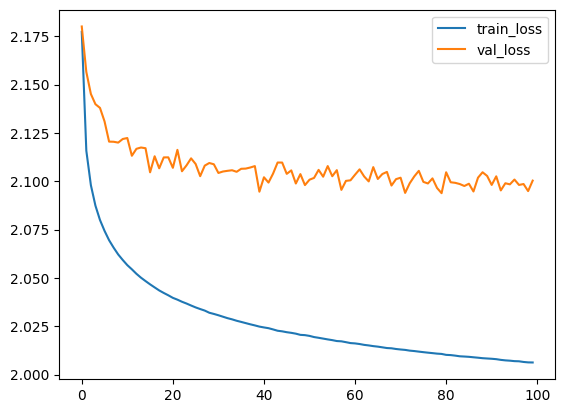

In [ ]:
model1 = SoftmaxRegression(num_inputs=3*32*32,num_outputs=10,lr=lr, wd=wd).to(device)
model1, train_loss, val_loss = train_model(model1, trainloader, valloader, num_epochs)
plt.plot(torch.arange(len(train_loss)),train_loss.detach().numpy(), label="train_loss")
plt.plot(torch.arange(len(val_loss)),val_loss.detach().numpy(), label="val_loss")
plt.legend()
plt.show()
torch.save(model1, '/content/drive/MyDrive/COMP540_Asst2/model1.pth')

# Build models for various learning rates and weight decays
- model2: lr=1e-3, wd=1e-3, num_epochs = 100
- model3: lr=1e-3, wd=1e-2, num_epochs = 100
- model4: lr=1e-1, wd=1e-2, num_epochs = 100
- model5: lr=1e-5, wd=1e-2, num_epochs = 100

In [ ]:
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

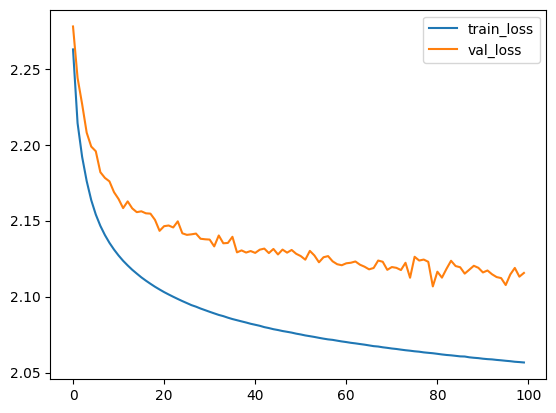

In [ ]:
# model2: lr=1e-3, wd=1e-3, num_epochs = 100
model2 = SoftmaxRegression(num_inputs=3*32*32,num_outputs=10,lr=1e-3, wd=1e-3).to(device)
model2, train_loss, val_loss = train_model(model2, trainloader, valloader, num_epochs)
plt.plot(torch.arange(len(train_loss)),train_loss.detach().numpy(), label="train_loss")
plt.plot(torch.arange(len(val_loss)),val_loss.detach().numpy(), label="val_loss")
plt.legend()
plt.show()
torch.save(model2, '/content/drive/MyDrive/COMP540_Asst2/model2.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

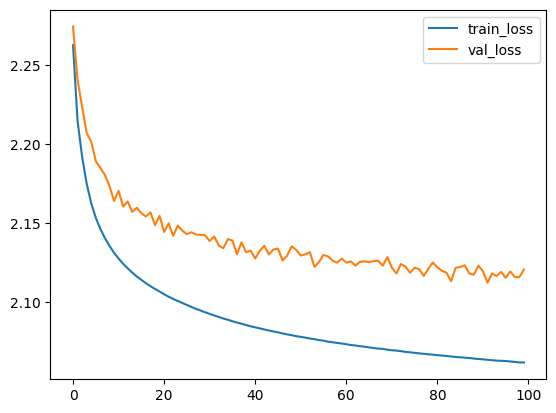

In [ ]:
# model3: lr=1e-3, wd=1e-2, num_epochs = 100
model3 = SoftmaxRegression(num_inputs=3*32*32,num_outputs=10,lr=1e-3, wd=1e-2).to(device)
model3, train_loss, val_loss = train_model(model3, trainloader, valloader, num_epochs)
plt.plot(torch.arange(len(train_loss)),train_loss.detach().numpy(), label="train_loss")
plt.plot(torch.arange(len(val_loss)),val_loss.detach().numpy(), label="val_loss")
plt.legend()
plt.show()
torch.save(model3, '/content/drive/MyDrive/COMP540_Asst2/model3.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

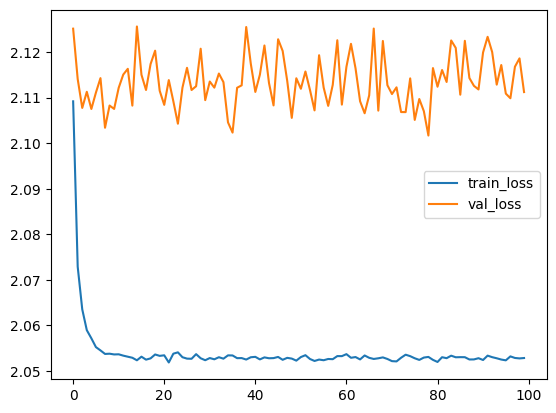

In [ ]:
# model4: lr=1e-1, wd=1e-2, num_epochs = 100
model4 = SoftmaxRegression(num_inputs=3*32*32,num_outputs=10,lr=1e-1, wd=1e-2).to(device)
model4, train_loss, val_loss = train_model(model4, trainloader, valloader, num_epochs)
plt.plot(torch.arange(len(train_loss)),train_loss.detach().numpy(), label="train_loss")
plt.plot(torch.arange(len(val_loss)),val_loss.detach().numpy(), label="val_loss")
plt.legend()
plt.show()
torch.save(model4, '/content/drive/MyDrive/COMP540_Asst2/model4.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

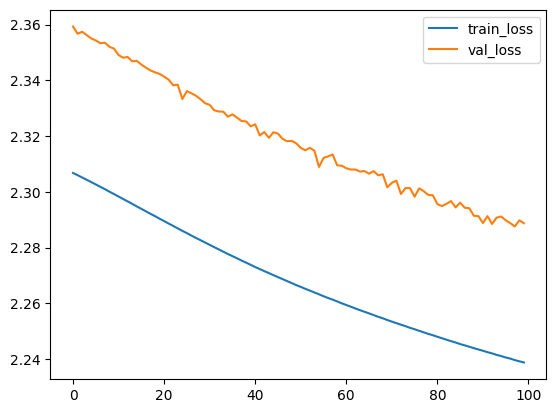

In [ ]:
# model5: lr=1e-5, wd=1e-2, num_epochs = 100
model5 = SoftmaxRegression(num_inputs=3*32*32,num_outputs=10,lr=1e-5, wd=1e-2).to(device)
model5, train_loss, val_loss = train_model(model5, trainloader, valloader, num_epochs)
plt.plot(torch.arange(len(train_loss)),train_loss.detach().numpy(), label="train_loss")
plt.plot(torch.arange(len(val_loss)),val_loss.detach().numpy(), label="val_loss")
plt.legend()
plt.show()
torch.save(model5, '/content/drive/MyDrive/COMP540_Asst2/model5.pth')

# Evaluate the performance of models (20 points)
- for each model, use the sklearn metrics functions to calculate on the test set
     - confusion matrix
     - accuracy
     - classification report
- build the function getTopKAcc() to calculate top_k_accuracy using the sklearn top_k_accuracy_score function with k = 1,2,3

In [ ]:
model1 = torch.load('/content/drive/MyDrive/COMP540_Asst2/model1.pth')
model2 = torch.load('/content/drive/MyDrive/COMP540_Asst2/model2.pth')
model3 = torch.load('/content/drive/MyDrive/COMP540_Asst2/model3.pth')
model4 = torch.load('/content/drive/MyDrive/COMP540_Asst2/model4.pth')
model5 = torch.load('/content/drive/MyDrive/COMP540_Asst2/model5.pth')

In [ ]:
models = [model1, model2, model3, model4, model5]

X_test, y_test = next(iter(testloader))

cm_models = []
acc_models = []
clftn_models = []

In [ ]:
for model in models:
    with torch.no_grad():
        # Calculate yhat for model
        yhat_test = model.predict(X_test)

        # Calculate confusion matrix (cm), accuracy and classification report (clf_rep) and store in list
        cm = cm_models.append(confusion_matrix(y_test, yhat_test))
        accuracy = acc_models.append(accuracy_score(y_test, yhat_test))
        clf_rep = clftn_models.append(classification_report(y_test, yhat_test))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




 ----------- Quality of model 0  -----------


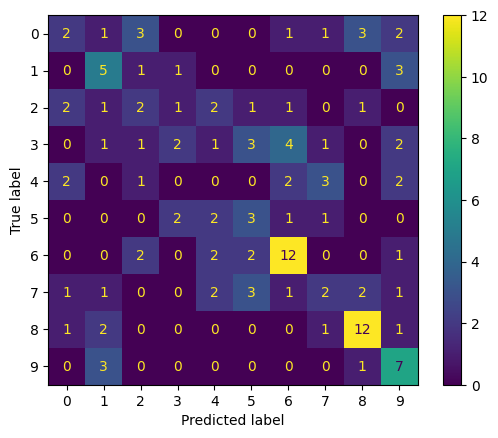


 Accuracy:  36.71875 %

 Classification Report: 
               precision    recall  f1-score   support

           0       0.25      0.15      0.19        13
           1       0.36      0.50      0.42        10
           2       0.20      0.18      0.19        11
           3       0.33      0.13      0.19        15
           4       0.00      0.00      0.00        10
           5       0.25      0.33      0.29         9
           6       0.55      0.63      0.59        19
           7       0.22      0.15      0.18        13
           8       0.63      0.71      0.67        17
           9       0.37      0.64      0.47        11

    accuracy                           0.37       128
   macro avg       0.32      0.34      0.32       128
weighted avg       0.35      0.37      0.34       128



 ----------- Quality of model 1  -----------


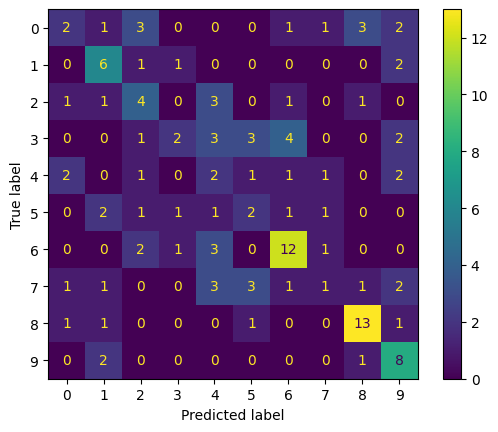


 Accuracy:  40.625 %

 Classification Report: 
               precision    recall  f1-score   support

           0       0.29      0.15      0.20        13
           1       0.43      0.60      0.50        10
           2       0.31      0.36      0.33        11
           3       0.40      0.13      0.20        15
           4       0.13      0.20      0.16        10
           5       0.20      0.22      0.21         9
           6       0.57      0.63      0.60        19
           7       0.20      0.08      0.11        13
           8       0.68      0.76      0.72        17
           9       0.42      0.73      0.53        11

    accuracy                           0.41       128
   macro avg       0.36      0.39      0.36       128
weighted avg       0.39      0.41      0.38       128



 ----------- Quality of model 2  -----------


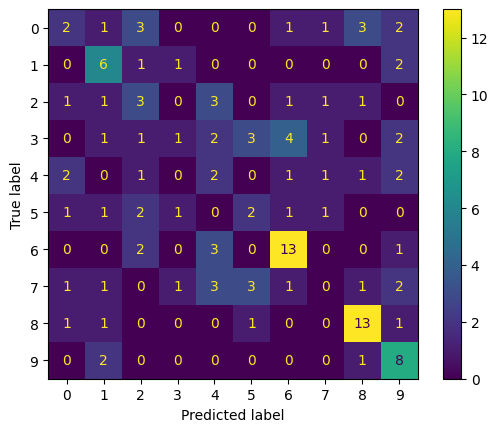


 Accuracy:  39.0625 %

 Classification Report: 
               precision    recall  f1-score   support

           0       0.25      0.15      0.19        13
           1       0.43      0.60      0.50        10
           2       0.23      0.27      0.25        11
           3       0.25      0.07      0.11        15
           4       0.15      0.20      0.17        10
           5       0.22      0.22      0.22         9
           6       0.59      0.68      0.63        19
           7       0.00      0.00      0.00        13
           8       0.65      0.76      0.70        17
           9       0.40      0.73      0.52        11

    accuracy                           0.39       128
   macro avg       0.32      0.37      0.33       128
weighted avg       0.34      0.39      0.35       128



 ----------- Quality of model 3  -----------


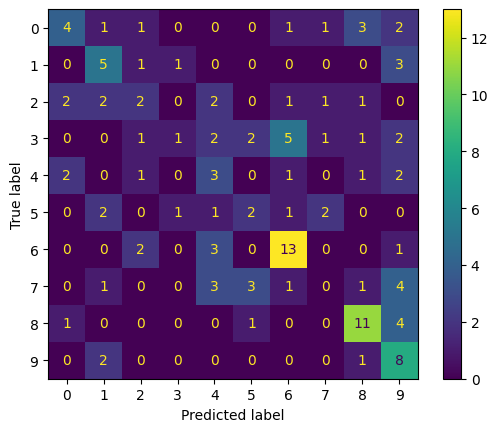


 Accuracy:  38.28125 %

 Classification Report: 
               precision    recall  f1-score   support

           0       0.44      0.31      0.36        13
           1       0.38      0.50      0.43        10
           2       0.25      0.18      0.21        11
           3       0.33      0.07      0.11        15
           4       0.21      0.30      0.25        10
           5       0.25      0.22      0.24         9
           6       0.57      0.68      0.62        19
           7       0.00      0.00      0.00        13
           8       0.58      0.65      0.61        17
           9       0.31      0.73      0.43        11

    accuracy                           0.38       128
   macro avg       0.33      0.36      0.33       128
weighted avg       0.36      0.38      0.35       128



 ----------- Quality of model 4  -----------


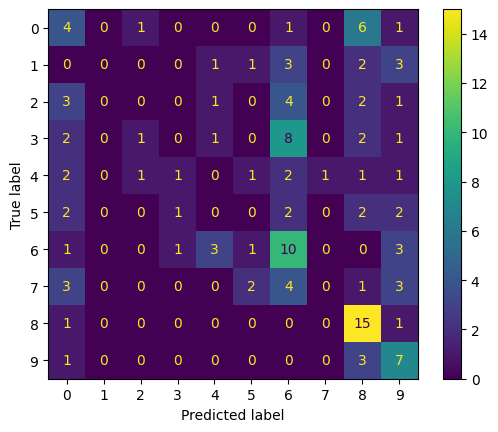


 Accuracy:  28.125 %

 Classification Report: 
               precision    recall  f1-score   support

           0       0.21      0.31      0.25        13
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         9
           6       0.29      0.53      0.38        19
           7       0.00      0.00      0.00        13
           8       0.44      0.88      0.59        17
           9       0.30      0.64      0.41        11

    accuracy                           0.28       128
   macro avg       0.13      0.24      0.16       128
weighted avg       0.15      0.28      0.19       128



In [ ]:
for i in range(len(models)):
    print("\n\n ----------- Quality of model", i, " -----------")
    cm_disp = sklearn.metrics.ConfusionMatrixDisplay(cm_models[i])
    cm_disp.plot()
    plt.show()

    print("\n Accuracy: ", acc_models[i]*100, "%")
    print("\n Classification Report: \n", clftn_models[i])

In [ ]:
def getTopKAcc(model,testloader,k=1):
    # YOUR CODE here to loop over the batches of test data to
    # calculate topK accuracy using the sklearn top_k_accuracy_score built in
    # remember to do all your work under torch.no_grad(), so that gradients of model are not updated!
    # return the top_k_accuracy score for the given model and test data set with the given k.
    X_test, y_test = next(iter(testloader))
    with torch.no_grad():
      yhat_test_proba = model.forward(X_test)

    top_k_accuracy = top_k_accuracy_score(y_test, yhat_test_proba, k=k)

    return top_k_accuracy_score(y_test, yhat_test_proba, k=k)

In [ ]:
# YOUR CODE HERE to run the getTopKAcc function for testloader with the five models for k = 1,2,3
TopKAcc = []
print("Top K Accuracies\n")
for i, model in enumerate(models):
    top_k_scores = []

    for k in [1, 2, 3]:
        # calculate and store top k scores for multiple k values
        top_k_scores.append(getTopKAcc(model, testloader, k))

    # Print scores for varying k
    print("\nTop K accuracies for model", i, "for k = 1, 2, 3 respectively are:\n", top_k_scores)

    # store the top k scores for all k values in main list
    TopKAcc.append(top_k_scores)

Top K Accuracies


Top K accuracies for model 0 for k = 1, 2, 3 respectively are:
 [0.3671875, 0.59375, 0.734375]

Top K accuracies for model 1 for k = 1, 2, 3 respectively are:
 [0.40625, 0.5859375, 0.6953125]

Top K accuracies for model 2 for k = 1, 2, 3 respectively are:
 [0.390625, 0.59375, 0.6484375]

Top K accuracies for model 3 for k = 1, 2, 3 respectively are:
 [0.3828125, 0.578125, 0.71875]

Top K accuracies for model 4 for k = 1, 2, 3 respectively are:
 [0.28125, 0.421875, 0.4765625]


# Best performing model (10 points)
- what is the learning rate and weight decay associated with the best performing model?
- comment on the effect of changing learning rate and weight decay on the basis of the five models you have built.
- use the visualization code below to understand the structure of the learned models under the different hyperparameters. Do you see a pattern in the coefficients as a function of learning rate, weight decay? Explain.

# Visualizing the learned models


In [ ]:
# Visualize the learned weights for each class`

def visualize_model(model):
    theta = model.net[1].weight.data.cpu().numpy() # [10,3072]
    theta = theta.reshape(10, 3, 32, 32)  # Because we read the image as 3*32*32 instead of 32*32*3
    theta=np.transpose(theta, (0,2,3,1)) # [10,32,32,3], so plt can plot it

    theta_min, theta_max = np.min(theta), np.max(theta)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    plt.figure(figsize=(8,8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        # Rescale the weights to be between 0 and 255
        thetaimg = 255.0 * (theta[i] - theta_min) / (theta_max - theta_min)
        plt.imshow(thetaimg.astype('uint8'),cmap='viridis')
        plt.axis('off')
        plt.title(classes[i])

    plt.tight_layout()
    plt.show()

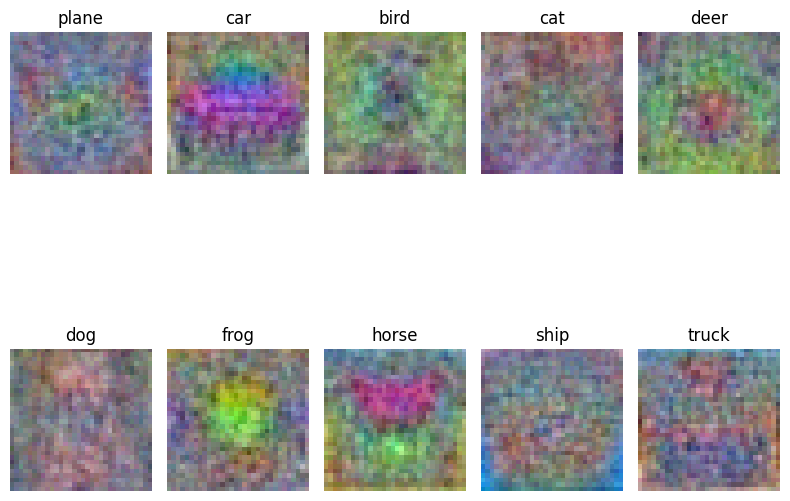

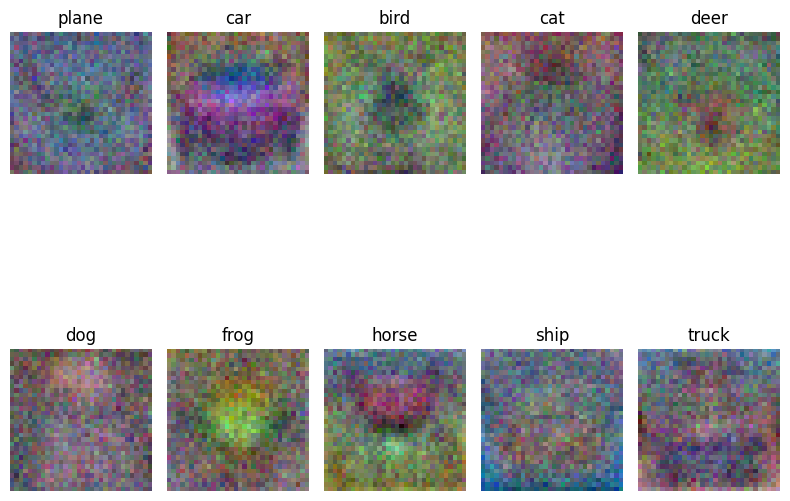

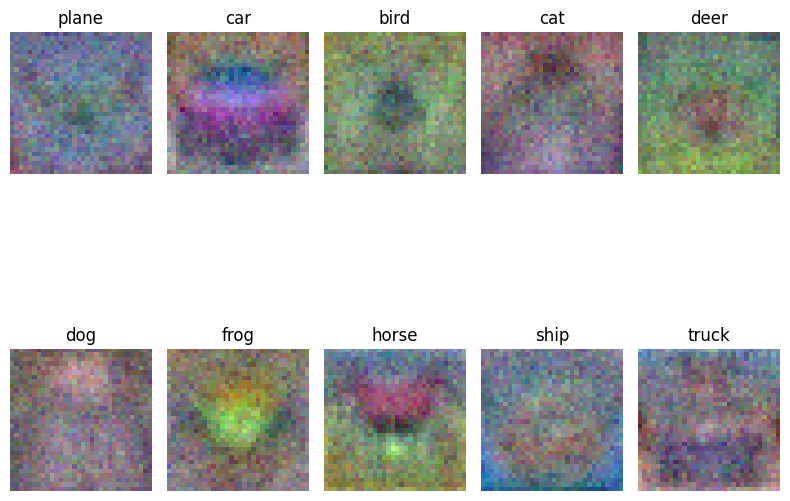

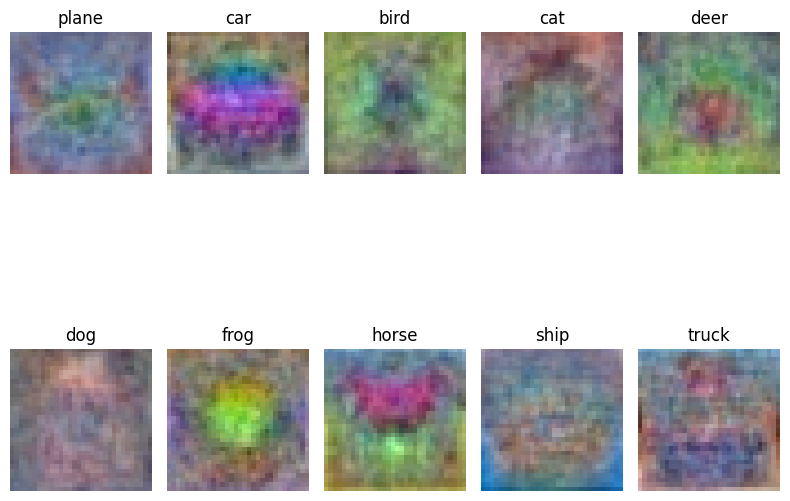

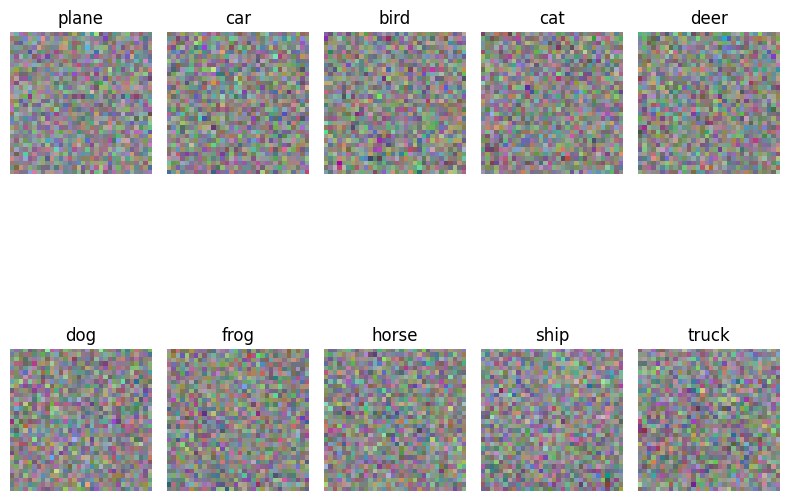

In [ ]:
# YOUR CODE HERE for visualizing model1, ..., model5
# comment on what patterns you see
# Are the coefficients of the best performing model more interpretable than the others?
for model in models:
    visualize_model(model)
